# Primer on Cipher Metrics

_Andrew Steckley, PhD_

_July 2020_

This notebooks describes several metrics that are useful in evaluating simple and homophonic substitution ciphers and cipher breaking activities.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-Letter-Frequency-Data" data-toc-modified-id="Load-Letter-Frequency-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load Letter Frequency Data</a></span></li><li><span><a href="#Instantiate-Zodiac-Z340-and-Z408-Ciphers" data-toc-modified-id="Instantiate-Zodiac-Z340-and-Z408-Ciphers-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Instantiate Zodiac Z340 and Z408 Ciphers</a></span></li></ul></li><li><span><a href="#Distance" data-toc-modified-id="Distance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Distance</a></span></li><li><span><a href="#Clarity" data-toc-modified-id="Clarity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clarity</a></span></li><li><span><a href="#Homophonicity" data-toc-modified-id="Homophonicity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homophonicity</a></span><ul class="toc-item"><li><span><a href="#Z408-Homophonicity" data-toc-modified-id="Z408-Homophonicity-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Z408 Homophonicity</a></span></li><li><span><a href="#Range-of-General-Homoponicity" data-toc-modified-id="Range-of-General-Homoponicity-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Range of General Homoponicity</a></span></li></ul></li><li><span><a href="#Generating-Cipher-Keys-with-Targeted-Values-of-Homophonicity" data-toc-modified-id="Generating-Cipher-Keys-with-Targeted-Values-of-Homophonicity-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generating Cipher Keys with Targeted Values of Homophonicity</a></span></li></ul></div>

## Setup

### Imports

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from cipherlib.CipherKey import CipherKey
from cipherlib.HomophonicCipher import HomophonicCipher
from cipherlib.LanguageModel import LanguageModel
from cipherlib.utils.ProgressBar import ProgressBar
from cipherlib.utils.display_utils import display_dataframe_with_style
import cipherlib.zodiac.Z408 as Z408
import cipherlib.zodiac.Z340 as Z340
import cipherlib.zodiac.Z32 as Z32
import cipherlib.zodiac.Z13 as Z13

from IPython.core.display import display, HTML

%reload_ext autoreload
%autoreload 2

### Load Letter Frequency Data

Relative letter frequencies are used for various statistical calculations. The main letter frequencies we will use has been derived using a language model developed specifically for the Zodiac ciphers. This language model is based on a large corpus of English documents (source from Google) combined with a corpus comprising all the writings sent to newspapers and authorities by the Zodiac Killer. The letter frequencies derived from this language model differ slightly from those found in common English alone. Below we load both letter distributions and show a comparison chart of the two.

In [2]:
zodiac_language_model = LanguageModel('language_model_n10____message_corpus_300x100000____message_generator_zodiac_0.5_0.5.pickle', 
                               persistent_directory='data/persist')
zodiac_language_relative_letter_frequencies = dict()
for letter in CipherKey.LETTERS:
    zodiac_language_relative_letter_frequencies[letter] = zodiac_language_model.distributions[1].prob(letter)
    

In [3]:
file = open('data/language/english_language_relative_letter_frequencies.pickle', "rb")
english_language_relative_frequencies = pickle.load(file)
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'data/language/english_language_relative_letter_frequencies.pickle'

In [4]:
letters = CipherKey.LETTERS[::-1]
english_values = [english_language_relative_frequencies[letter] for letter in letters]
zodiac_values = [zodiac_language_relative_letter_frequencies[letter] for letter in letters]
letters = list(letters)

df = pd.DataFrame.from_dict({'letter': letters,
                           'English':english_values, 
                             'Zodiac':zodiac_values}) 
df.head()

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.barh(ind + width, df.English, width, color='pink', label='English')
ax.barh(ind, df.Zodiac, width, color='green', label='Zodiac')

ax.set(yticks=ind + width, yticklabels=df.letter, ylim=[2*width - 1, len(df)])
ax.legend()
ax.set_xlabel('Frequency (Percentage of Characters)')
ax.set_title("Relative Letter Frequencies")

plt.show()

NameError: name 'english_language_relative_frequencies' is not defined

### Instantiate Zodiac Z340 and Z408 Ciphers

In [5]:
z340 = Z340()
z408 = Z408()

Now let's look closer at the Z408 cipher key.

In [6]:
num_symbols_per_letter = z408.cipher_key.num_symbols_per_letter()
reverse_key = z408.reverse_key()
symbol_sets = [",".join(reverse_key[letter]) for letter in CipherKey.LETTERS]
num_symbols = [num_symbols_per_letter[letter] for letter in CipherKey.LETTERS]
letter_frequency = [zodiac_language_relative_letter_frequencies[letter] for letter in CipherKey.LETTERS]
df = pd.DataFrame( {'symbols': symbol_sets, 
                    'num symbols':num_symbols,
                   'relative frequency':letter_frequency}, 
                  index=list(CipherKey.LETTERS))
df = df.sort_values(by='relative frequency', ascending=False)
df['relative frequency'] = [f"{zodiac_language_relative_letter_frequencies[letter]:.2%}" for letter in df.index]

display_dataframe_with_style(df, ['symbols'], 'Zodiac_Oranchak', font_size='12pt')


,symbols,num symbols,relative frequency
e,"+,6,E,N,W,Z,p",7,11.74%
t,"5,H,I,L",4,9.44%
o,"!,T,X,d",4,7.84%
a,"8,G,S,l",4,7.52%
i,"9,P,U,k",4,7.51%
n,"(,D,O,^",4,6.41%
h,"),M",2,6.27%
s,"7,@,F,K",4,5.85%
l,"#,%,B",3,4.99%
r,"\,r,t",3,4.98%


## Distance

A cipher key consists of a set of symbol-to-letter mappings or SLMs. Each SLM specifies a symbol along with the letter that it encodes. In the case of a simple substitution cipher, there is one unique symbol to encode each letter and so there is $n_{symbol}$ SLMs where $n_{symbols}=n_{letters}$. 

For homophonic ciphers in general, each symbol will encode one and only one letter, but there may be more than one symbol encoding any particular letter. Hence there is still $n_{symbol}$ SLMs but $n_{symbols}\ge n_{letters}$.

We can define a logical "distance" between two cipher keys as the total number of symbols for which there is an SLM in either key that is either absent in the other key or different with respect to the letter to which it maps.  This concept is most straightforward when the two keys contain SLMs for the same set of symbols. Then the distance represents the number of SLMs for which the letter components must be modified if one wants the SLMs to agree in both cipher keys.

In cases where the cipher keys' SLMs cover different symbol sets, either wholly or partially, we include also the number of missing SLM's that must be added to get the two cipher keys to agree.

In short, the distance is the minimum number of steps that must taken to transform one key into the other, where a step is defined as the modification of an SLM or the addition/removal of an SLM.

## Clarity

A second useful metric is "clarity", which gages how well a candidate cipher key accurately decodes a particular message.
Clarity is defined as the proportion of correctly decoded letters that a cipher key produces when applied to a particular ciphertext. The clarity will range from 0% if the key fails to decode any letter correctly to 100% if it decodes every letter correctly. 

Clarity is related to distance, but it has some important differences. In particular, a clarity of 100% does not mean that every SLM is correct and that the distance between the candidate cipher key and the true cipher key is 0.
This is because a particular message may not contain every alphabetic letter and so the ciphertext will not contain all symbols. A clarity of 100% only guarantees that all SLMs for the symbols that do actually occur in the ciphertext are correct within the candidate cipher key.

## Homophonicity

Homophonicity provides a measure of the amount of information obfuscation that is present in a cipher. We define it as: 

$$h = -log_2(2 \sum_{a} \frac{\frac{C_a}{L}}{1 + n_a} )$$

where 
 * $C_a$ is the count of occurrences of a letter $a$ within the decoded message 
 * $n_a$ is the number of symbols assigned to encode the letter, 
 * $L$ is the length of the encoded message 

and the sum is taken over all letters used in the message. 

A homophonicity of 0 corresponds to a simple substitution cipher with a single symbol encoding each letter.  As letters are encoded using more and more symbols, the homophonicity increases. Assigning additional symbols to encode more common letters raises the homophonicity more than when those additional symbols are assigned to rare letters.
           
This measure of homophonicity is specific to a particular cipher, by which we mean a cipher key along with a particular message and its ciphertext encoding. Where needed for clarity, we can refer to this as the "specific homophonicity" of the cipher.
 
We can also define a "general homophonicity", which is a function of the cipher key alone, to provide the expected value of specific homophonicity across all potential messages and their encodings. For this metric, we modify the above definition to use the probability of each letter within the source language instead of the relative count of letters within the message. This effectively provides the expected value of relative letter count across potential messages. General homophonicity is given by 
    
$$h_g = -log_2(2 \sum_{a} \frac{P_a}{1 + n_a} )$$

where 
 * $P_a$ is the probability of the letter within the source language

Note that, in the denominator of the summed terms, the addition of 1 to the number of symbols simply provides for a consistent formula for both general and specific homophonicities, while accommodating for letters in the source language alphabet that do not occur in the specific cipher message. 






Note:
> An alternative name that I considered for the measure was “obfiscuity”. Unfortunately neither homophonicity nor obfiscuity roll off the tongue easily (and it's always a nuisance to use the letter “o” in a mathematical equation.)

### Z408 Homophonicity

The Z408 cipher uses 54 symbols to encode 23 letters of the alphabet. (It does not use the letters 'j', 'q', or 'z').

In [7]:
z408_homophonicity = z408.specific_homophonicity()
print(f"Specific Homophonicity of the Z408 Cipher is {z408_homophonicity:.5f}")

Specific Homophonicity of the Z408 Cipher is 0.85758


For the general homophonicity, we need consider only the cipher key.

In [8]:
z408_cipher_key = z408.cipher_key
z408_num_symbols = len(z408.cipher_key.key)
z408_unused_letters = z408.unused_letters()

z408_general_homophonicity = z408_cipher_key.general_homophonicity(num_symbols=z408_num_symbols, 
                                                                   unused_letters=z408_unused_letters)
print(f"General Homophonicity of the Z408 cipher key is {z408_general_homophonicity:.5f}")

General Homophonicity of the Z408 cipher key is 0.85924


That evaluation is for a cipher key exactly as it is for the Z408 cipher. But since the Z408 cipher does not make use of 'j', 'q', or 'z', that particular cipher key cannot encode any plaintext message that happens to include any of those letters. Depending on the purpose at hand, we may sometimes want to evaluate a general homophonicity for an extended version of the cipher key -- one that includes an additional symbol for each of the three unused letters. This will change the value of general homophonicity slightly.

In [9]:
z408_general_homophonicity = z408_cipher_key.general_homophonicity(num_symbols=z408_num_symbols, 
                                                                   unused_letters=z408_unused_letters,
                                                                  extend_symbols=True)
print(f"General Homophonicity of the Extended Z408 cipher key is {z408_general_homophonicity:.5f}")

General Homophonicity of the Extended Z408 cipher key is 0.83677


### Range of General Homoponicity

Homophonicity can provide a useful measure of the complexity of a cipher key, but while it depends on the number of symbols used and the number of letters covered, (as well as the relative letter frequencies across all potential messages), it is not a deterministic function of these parameters. Once one moves beyond a simple substitution cipher, where $n_{symbol}=n_{letter}$, there are multiple ways to arrange the symbol-to-letter mappings (SLMs) that make up a possible cipher key.

This means that for any given number of symbols (and of letters and their relative frequencies), there is a range of possible specific homophonicities that are produced by potential messages. Knowing this range can be useful for investigating an unsolved cipher for which we do not know the cipher key SLMs. Fortunately, we can easily evaluate the range empirically. 

First we assume that every letter may be required for the decoded message, so we assume 
$$n_{letter}=26 \le n_{symbol} $$  

And we assume that each letter must have at least one encoding symbol assigned to it. After defining $n_{letter}$ SLMs for that purpose (of which there is a huge number or arbitrary solutions), we are left with the multitude of ways that the excess $n_{symbol}-n_{letter}$ may be assigned to letters.

The minimum value of homophonicity is obtained when the excess symbols are assigned such that the least amount of information is obfuscated. This occurs when a maximum number of symbols are mapped each to single letters. We can achieve this by assigning all of the _excess_ symbols to whatever letter has the lowest expected frequency of occurrence. In normal English this is the letter 'q'.  So if we have, for example, $n_{symbol}=63$ (as in Z340), then the cipher key that will produce the lowest general homophonicity is one in which there is a single symbol used to encode every letter except 'q', which will have 38 symbols encoding it.  This is a very unlikely choice of cipher key design, of course, but it does represent the minimum possible homophonicity.

Evaluating the maximum value of homophonicity is a little more involved. But we can do so by systematically assigning the excess symbols one at at time to whichever letter increases homophonicity the most by way of its corresponding term in the homphonicity formula's summation. This just requires evaluating the gradient of the sum with respect to each potential letter that a symbol can be assigned, and then choosing that with the greatest gradient for the next symbol assignment. And then we do this repeatedly until all the excess symbols are assigned.



Now let's use this empircal approach to get the general homophonicity ranges for the Z408 and Z340 ciphers.

In [10]:
z408_cipher_key = z408.cipher_key
z408_num_symbols = len(z408.cipher_key.key)
z408_min_value, z408_max_value = CipherKey.homophonicity_range(num_symbols=z408_num_symbols)
print(f"The range of homophonicity for a Z408-like cipher key is: [{z408_min_value:.5f}, {z408_max_value:.5f}]")

z340_cipher_key = z340.cipher_key
z340_num_symbols = len(z340.cipher_key.key)
z340_min_value, z340_max_value = CipherKey.homophonicity_range(num_symbols=z340_num_symbols)
print(f"The range of homophonicity for a Z340-like cipher key is: [{z340_min_value:.5f}, {z340_max_value:.5f}]")

The range of homophonicity for a Z408-like cipher key is: [0.00083, 0.83342]
The range of homophonicity for a Z340-like cipher key is: [0.00084, 1.00906]


We can look at the way the range varies with the number of symbols (while keeping $n_{letter}=26$ and using the same letter distributions  as derived from our language model.)

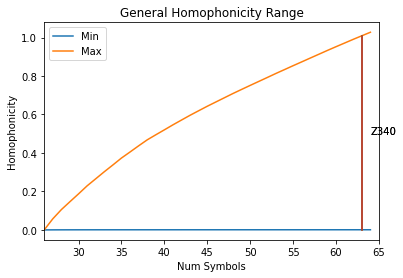

In [11]:
minimums = list()
maximums = list()
ns = np.arange(26,65)
for num_symbols in ns:
    minimum, maximum = CipherKey.homophonicity_range(num_symbols=num_symbols)
    minimums.append(minimum)
    maximums.append(maximum)
    
plt.plot(ns, minimums, label="Min")
plt.plot(ns, maximums, label="Max")
plt.legend()
plt.title("General Homophonicity Range")
plt.xlabel("Num Symbols")
plt.ylabel("Homophonicity")
plt.plot([z340_num_symbols,z340_num_symbols], [z340_min_value, z340_max_value], linestyle='-')
plt.text(z340_num_symbols+1, .5, 'Z340')
plt.plot([z340_num_symbols,z340_num_symbols], [z340_min_value, z340_max_value], linestyle='-')
plt.text(z340_num_symbols+1, .5, 'Z340')
plt.xlim((26,65))
plt.show()


It is clear here that the maximum bound increases sub-linearly with the number of symbols. The minimum bound also increases, but at a much lower rate so it is not apparent in the above graph. In the graph below, showing just the minimum boundary, we can see better how it also varies sub-linearly with number of symbols.


39


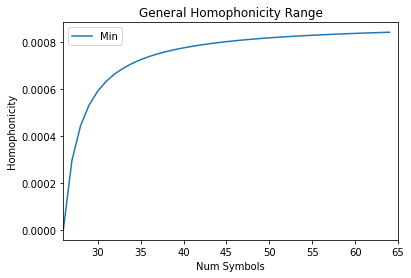

In [12]:
print(len(minimums))
plt.plot(ns, minimums, label="Min")
plt.legend()
plt.title("General Homophonicity Range")
plt.xlabel("Num Symbols")
plt.ylabel("Homophonicity")
plt.xlim((26,65))
plt.show()

Now let's look at where the Z408 homophonicities land on this graph.

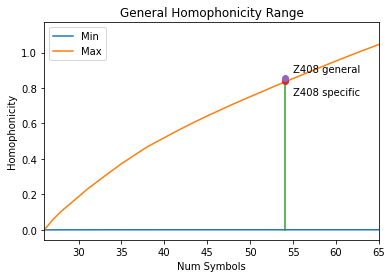

In [23]:
minimums = list()
maximums = list()
ns = np.arange(26,70)
for num_symbols in ns:
    minimum, maximum = CipherKey.homophonicity_range(num_symbols=num_symbols)
    minimums.append(minimum)
    maximums.append(maximum)

minimum_Z408, maximum_Z408 = CipherKey.homophonicity_range(num_symbols=z408_num_symbols)
    
plt.plot(ns, minimums, label="Min")
plt.plot(ns, maximums, label="Max")
plt.legend()
plt.title("General Homophonicity Range")
plt.xlabel("Num Symbols")
plt.ylabel("Homophonicity")
plt.plot([z408_num_symbols, z408_num_symbols], [minimum_Z408, maximum_Z408], linestyle='-')
plt.plot([z408_num_symbols],[z408_general_homophonicity], marker='o')
plt.plot([z408_num_symbols],[z408_homophonicity], marker='o')
plt.text(z408_num_symbols+1, z408_general_homophonicity+.05, 'Z408 general')
plt.text(z408_num_symbols+1, z408_homophonicity-.1, 'Z408 specific')

plt.xlim((26,65))
plt.show()
plt.show()


Though it is not apparent from the graph, the general homophonicity value falls just outside the calculated range. 

In [24]:
print(f"Maximum General Homophonicity for {z408_num_symbols} symbols: {maximum_Z408:.5f}")
print(f"General Homophonicity for Z408: {z408_general_homophonicity:.5f}")



Maximum General Homophonicity for 54 symbols: 0.83342
General Homophonicity for Z408: 0.83677


The reason for this is that we have compared the general homophonicity value based on 54 symbols encoding 23 letters to the range that is possible using 54 symbols encoding 26 letters.
To compare things consistently, we need to look at the case where we extend the Z408 key with 3 extra symbols so as to be able to cover all 26 letters. (We could alternatively look at the range using a reduced alphabet of 23 letters.)

__@TBD ... SOMETHING STILL WRONG HERE.. is using 23 letters__

Maximum General Homophonicity for 57 symbols = 0.89342
General Homophonicity for z408 is 0.83677


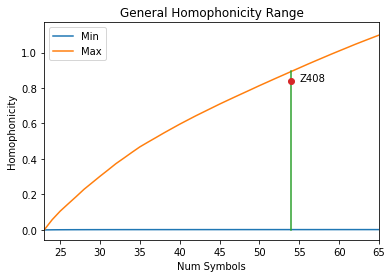

In [27]:
minimums = list()
maximums = list()
ns = np.arange(23,67)
for num_symbols in ns:
    minimum, maximum = CipherKey.homophonicity_range(num_symbols=num_symbols, 
                                                     unused_letters=z408_unused_letters, 
                                                     extend_symbols=True)
    minimums.append(minimum)
    maximums.append(maximum)

minimum_Z408_extended, maximum_Z408_extended = CipherKey.homophonicity_range(num_symbols=z408_num_symbols, 
                                                                             unused_letters=z408_unused_letters, 
                                                                             extend_symbols=True)
    
z408_num_symbols_extended = z408_num_symbols + len(z408_unused_letters)
print(f"Maximum General Homophonicity for {z408_num_symbols_extended} symbols = {maximum_Z408_extended:.5f}")
print(f"General Homophonicity for z408 is {z408_general_homophonicity:.5f}")

plt.plot(ns, minimums, label="Min")
plt.plot(ns, maximums, label="Max")
plt.legend()
plt.title("General Homophonicity Range")
plt.xlabel("Num Symbols")
plt.ylabel("Homophonicity")
plt.plot([z408_num_symbols, z408_num_symbols], [minimum_Z408_extended, maximum_Z408_extended], linestyle='-')
plt.text(z408_num_symbols+1, z408_general_homophonicity, 'Z408')
plt.plot([z408_num_symbols],[z408_general_homophonicity], marker='o')
plt.xlim((23,65))
plt.show()

Now we see that the Z408 general homophonicity does in fact fall within the calculated range. Not surprisingly, we  also see that the designer of Z408 was likely aiming intentionally at a high degree of obfuscation (i.e. homophonicity). But it also shows that the designer did not attain the maximum obfuscation that he could have with the use of 54 symbols. 


## Generating Cipher Keys with Targeted Values of Homophonicity

Now it is also useful to be able to generate a random cipher key that has a targeted value of homophonicity. 
We can do this using an interative process.  The algorithm to find a cipher key with target homophonicity is as follows:
 * First a random key (with the desired $n_{symbol}$ symbols) is generated and its homophonicity is calculated.
 * Then one looks at all the possible ways to re-assign a single SLM, thereby increasing the number of symbols for a letter by one, while decreasing that of another by one. The set of cases considered here is only constrained by the fact that every letter must have at least one symbol encoding it so the minimum number of symbols for each letter is 1.
 * The homophonicity values for all these possible mutated keys is evaluated. 
 * All these homophonicities are then arranged in a 2D array of size $n_{letter} \times n_{letter}$. The target homophonicity value is subtracted from, and the absolute value taken, for every cell in the 2D array.
 * The cell with the minimum value now represents (by its row and column index) a mutation of the cipher key that will move its homophonicity value most productively towards the target value.
 * One can then continue mutating the key iteratively using the above process until the target homophonicity is achieved to some specified precision (or until a boundary value is reached in the case where the targeted value falls outside the possible range.)
 
A couple of examples are shown below. 


In [16]:
z408_specific_homophonicity = z408.specific_homophonicity()
print(f"Target homophonicity = {z408_specific_homophonicity:.5f}")
ck = CipherKey(target_homophonicity=(z408_specific_homophonicity, 
                                     zodiac_language_relative_letter_frequencies, 0.001),
              cipher_font='Zodiac_Oranchak')
print(f"Achieved homophonicity = {ck.general_homophonicity():.5f}")
ck.display_reverse_key(cipher_font='Zodiac_Oranchak')

Target homophonicity = 0.85758
Achieved homophonicity = 0.85748


Letter,Symbols
a,! # %
b,& (
c,)
d,* + -
e,. 0 1
f,2 3 4
g,5 6 7
h,8 9 :
i,; = ?
j,@ A


In [11]:
CipherKey.set_num_symbols(54)
z408_specific_homophonicity = z408.specific_homophonicity()
print(f"Target homophonicity = {z408_specific_homophonicity:.5f}")
ck = CipherKey(target_homophonicity=(z408_specific_homophonicity, 
                                     zodiac_language_relative_letter_frequencies, 0.001),
              cipher_font='Zodiac_Oranchak')
print(f"Achieved homophonicity = {ck.general_homophonicity():.5f}")
ck.display_reverse_key(cipher_font='Zodiac_Oranchak')

Target homophonicity = 0.85758
Cannot achieve 0.85758. Target will be reset to maximum possible which is 0.83342
Achieved homophonicity = 0.83342


Letter,Symbols
a,! # %
b,&
c,( )
d,* +
e,- . 0 1
f,2
g,3
h,4 5 6
i,7 8 9
j,:


In [47]:
CipherKey.set_num_symbols(54)
z408_specific_homophonicity = z408.specific_homophonicity()
print(f"Target homophonicity = {z408_specific_homophonicity:.5f}")
ck = CipherKey(target_homophonicity=(z408_specific_homophonicity-.1, 
                                     zodiac_language_relative_letter_frequencies, 0.001),
              cipher_font='Zodiac_Oranchak')
print(f"Achieved homophonicity = {ck.general_homophonicity():.5f}")
ck.display_reverse_key(cipher_font='Zodiac_Oranchak')

Target homophonicity = 0.85758
Achieved homophonicity = 0.75714


Letter,Symbols
a,! # %
b,& ( )
c,*
d,+ -
e,. 0 1
f,2 3
g,4
h,5 6 7 8
i,9 :
j,;


In [36]:
old = 'projects/project_1/data/validation/y7_gene_sensor_04_26/modal/k/20200426-135244/Y7_gene_sensor_00001.csv'
new = 'projects/project_1/data/validation/y7_gene_sensor_debug/modal/k/4x1000_300/20200716-211840/5/Y7_gene_sensor_00001.csv'

In [29]:
df_old= pd.read_csv(old)

In [31]:
df_old.columns


Index(['case_id', 'message_id', 'target_key_id', 'baseline_key_id',
       'gened_key_id', 'num_established_hit_genes', 'distance',
       'spike_gram_id', 'gene_rep_id', 'spike_gram',
       ...
       'gs_1_25', 'gs_2_25', 'gs_3_25', 'gs_4_25', 'gs_5_25', 'gs_6_25',
       'gs_7_25', 'gs_8_25', 'gs_9_25', 'hit'],
      dtype='object', length=559)

In [32]:
df_new= pd.read_csv(new)
df_new.columns

Index(['case_id', 'message_id', 'target_key_id', 'baseline_key_id',
       'gened_key_id', 'num_established_hit_genes', 'distance',
       'spike_gram_id', 'gene_rep_id', 'spike_gram',
       ...
       'gs_1_25', 'gs_2_25', 'gs_3_25', 'gs_4_25', 'gs_5_25', 'gs_6_25',
       'gs_7_25', 'gs_8_25', 'gs_9_25', 'hit'],
      dtype='object', length=559)

In [34]:
df_new.iloc[0]

case_id                 22
message_id               1
target_key_id           21
baseline_key_id         22
gened_key_id            25
                    ...   
gs_6_25           -24.7945
gs_7_25           -24.7945
gs_8_25           -24.7945
gs_9_25           -24.7945
hit                      1
Name: 0, Length: 559, dtype: object

In [35]:
df_old.iloc[0]

case_id                      1
message_id                   1
target_key_id                1
baseline_key_id              2
gened_key_id                 3
                      ...     
gs_6_25            1.68571e-15
gs_7_25            1.16406e-27
gs_8_25            4.62032e-06
gs_9_25            2.08921e-18
hit                          1
Name: 0, Length: 559, dtype: object

In [37]:
for i in range(len(df_old.columns)):
    print(f"{df_old.columns[i]}   {df_old[df_old.columns[i]][i]}")

case_id   1
message_id   1
target_key_id   1
baseline_key_id   2
gened_key_id   7
num_established_hit_genes   3
distance   7
spike_gram_id   3
gene_rep_id   16
spike_gram   this
gene_rep   RgTiUtWh
message   zbuttonsipromicedtopunishthemificouldhaveoneofthebestexamplesofthecircleoflightaboutthreetosixinchesacrosswhenthisisallovertheplaceasaresultofeconomicadvisershadawhilebackthenewbombissetyouhavejustparkedtheirtellingliesaboutmesoishalldescribemymasterpiecetoyouthenicepartofitjustmightsavethatisrather
a_0   0.0
a_1   0.0
a_2   0.0
a_3   0.0
a_4   0.0
a_5   1.0
a_6   0.0
a_7   1.0
a_8   0.0
a_9   0.0
a_10   0.0
a_11   1.0
a_12   0.0
a_13   1.0
a_14   0.0
a_15   0.0
a_16   0.0
a_17   0.0
a_18   0.0
a_19   1.0
a_20   0.0
a_21   0.0
a_22   0.0
a_23   0.0
a_24   0.0
a_25   0.0
bs_0_0   0.0017996275054588328
bs_1_0   0.7341701069144854
bs_2_0   0.9723900421992691
bs_3_0   0.9926138156603991
bs_4_0   0.7823979501811619
bs_5_0   5.3031403343282425e-176
bs_6_0   1.005000230605551e-29
bs_7_0  

In [38]:
for i in range(len(df_new.columns)):
    print(f"{df_new.columns[i]}   {df_new[df_new.columns[i]][i]}")

case_id   22
message_id   1
target_key_id   21
baseline_key_id   22
gened_key_id   35
num_established_hit_genes   23
distance   33
spike_gram_id   3
gene_rep_id   15
spike_gram   ling
gene_rep   GiKsVhWa
message   donotdothisiwilltrytosloidownorishalldomythingtoprovethishereisabloodstainedpieceofhisshirtilooklikeroutinerobberieskillingsiweartransparentfingertipguardsalltheihavekilledwillbecomemyslavesilooklikethedescriptionpassedoutonlyiamthetimeilookentirledifferentiwasatthisishallstatesomefactswhichonlyiand
a_0   0.0
a_1   0.0
a_2   0.0
a_3   0.0
a_4   1.0
a_5   0.0
a_6   1.0
a_7   1.0
a_8   1.0
a_9   0.0
a_10   0.0
a_11   0.0
a_12   0.0
a_13   1.0
a_14   0.0
a_15   0.0
a_16   0.0
a_17   0.0
a_18   0.0
a_19   0.0
a_20   0.0
a_21   0.0
a_22   0.0
a_23   0.0
a_24   0.0
a_25   0.0
bs_0_0   -5.2299119461122165
bs_1_0   -5.412779355835007
bs_2_0   -5.229911946112215
bs_3_0   -9.099337831797003
bs_4_0   -5.507489782858845
bs_5_0   -3.9952411928124194
bs_6_0   -9.049562443305373
bs_7_0   -1

In [41]:
new_y5 = 'projects/project_1/data/train/y5_symbol_mutations_debug/modal/2x1000_300/20200716-200226/Y5_symbol_mutations_00001.csv'

In [42]:
df_y5= pd.read_csv(new_y5)
df_y5.columns
for i in range(len(df_y5.columns)):
    print(f"{df_y5.columns[i]}   {df_y5[df_y5.columns[i]][i]}")

case_id   1
message_id   1
target_key_id   3
distance   2
candidate_key_id   4
mutation_symbol_index   0
message   speakingiamthemurdererofzodiacbuttonslikepeaceblackpowermelvineatsbluberetcthepoliceknowchristmassbrandnameofammosuperxtenshotsfiredboywasonbackfeettocardriversshouldhavejustparkedtheirtellingliesabouttimeforwhatisaiditwasabouttimeforwhatisaiditwasaboutsevenyearspriorshediedhardshesquirmedandthewest
0   -3.0907443495175446
1   -3.99524119281242
2   -5.264937709909621
3   -3.0907443495175446
4   -3.4056084038249583
5   -5.633902348366932
6   -4.325506565767001
7   -9.099337831797003
8   -5.303650959551495
9   -4.325506565767001
10   -5.518152194672532
11   -9.049562443305373
12   -5.264937709909621
13   -6.340860676150322
14   -3.7345535020191862
15   -3.405608403824957
16   -10.666266082022196
17   -5.507489782858846
18   -5.621637536928756
19   -3.995241192812421
20   -3.673171227752221
21   -6.617443261282308
22   -5.2299119461122165
23   -4.095172971617542
24   -9.04956

521   0.0
522   1.3279509240054497
523   6.270537260356272
524   1.5742934243193716
525   1.9915047695065693
526   0.12354970370766695
527   0.0
528   0.0
529   0.07640070157523482
530   0.0
531   0.0
532   3.8085836482647486
533   -1.2143896555016909e-08
534   0.0
535   0.0
536   0.0
537   0.0
538   0.0
539   0.0
540   0.0
541   0.0
542   0.219000907617712
543   0.5746019700324752
544   -3.899209843893914e-10
545   0.8519771320279509
546   0.0
547   0.0
548   0.0
549   0.0
550   -3.5207322466147035
551   0.0
552   0.0
553   1.59807935569469
554   0.0
555   0.0
556   0.0
557   0.0
558   0.0
559   0.0
560   0.0
561   0.6608210282945937
562   0.13497402133869585
563   -0.016510026555174306
564   5.117805323181212
565   0.0
566   0.007155298717052006
567   4.871171154332947
568   1.2951392161490458
569   0.0
570   0.0
571   0.0
572   1.5803023756241004
573   0.214527179971558
574   5.620996522312449
575   0.0
576   0.7837651993579904
577   0.9298241713096758
578   0.3130875387741199
579  

KeyError: 1000